In [296]:
cd ~/microbiome_rnn/

/Volumes/export/isn/mwiest/microbiome_rnn


In [348]:
from __future__ import print_function
import os
import torch
import numpy as np
import pandas as pd
import sys
from dev.otu_handler import OTUHandler, clr
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from scipy.stats.mstats import zscore
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from scipy.spatial.distance import cosine
import matplotlib.animation as animation
from copy import copy
import seaborn as sns
%matplotlib inline
from IPython.display import HTML
import random
import matplotlib


In [298]:
def complete_and_multiindex_df(df, split_char):
    default_tax = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    s = list(df.index.values)
    lt = [list(ls.split(split_char)) for ls in s]
    lt = [[ltii.strip() for ltii in lti] for lti in lt]
    for l in lt:
        if len(l) < len(default_tax):
            l += default_tax[-(len(default_tax)-len(l)):]

    ltn = pd.DataFrame(np.array(lt))
    ltn.index = df.index
    ltn.columns = default_tax
    combined = pd.concat((df, ltn), axis=1)
    combined.set_index(default_tax, inplace=True)
    return combined


In [299]:
data_dir = 'input_data/summed_completed_no_chloro/'
input_dir = 'all_strains_top_N/'

input_dir = os.path.join(data_dir, input_dir)

input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
files = input_files #+ test_files
files.sort()
print('\n\n'.join(files))
oh = OTUHandler(files)

# This is a more readable naming convention for the files. 
# Basically rob knight is the last two samples.
# file_labs = ['Donor$_0$', 'Donor$_1$', 'Donor$_3$', 'Donor$_{2, 0}$', 'Donor$_{2, 1}$']
file_labs = ['Donor$_{}$'.format(i) for i in range(len(files))]

input_data/summed_completed_no_chloro/all_strains_top_N/1015-reference-hit_metadata_1015:F01_feces_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv

input_data/summed_completed_no_chloro/all_strains_top_N/1015-reference-hit_metadata_1015:M01_feces_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv

input_data/summed_completed_no_chloro/all_strains_top_N/1015-reference-hit_metadata_1015:M02_feces_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv

input_data/summed_completed_no_chloro/all_strains_top_N/10283_combined_biom_LS_feces_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv

input_data/summed_completed_no_chloro/all_strains_top_N/11052_combined_biom_F04_stool_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv

input_data/summed_completed_no_chloro/all_strains_top_N/11052_combined_biom_F20_stool_sorted_tax_truncated_sorted_completed_normalized_sub_36.csv

input_data/summed_completed_no_chloro/all_strains_top_N/11052_combined_biom_M03_

# Group the strains by taxonomy levels and define a colormap

In [300]:
# How many taxonomy levels to include in the plots. 
# Higher numbers results in a a larger number of strains, ie less grouping
levels = 4
join_char = '\n'
split_char = ';'
# Reindex the dataframes
multi_samples = [complete_and_multiindex_df(s, split_char) for s in oh.samples]

In [301]:

# Get various pieces of data about the taxonomy.
grouped = [ms.groupby(level=list(range(0, levels))) for ms in multi_samples]
# Taxonomy names
labels = [join_char.join(c) for c in grouped[0].count().index]

['k__Bacteria\np__Actinobacteria\nc__Actinobacteria\no__Actinomycetales', 'k__Bacteria\np__Actinobacteria\nc__Coriobacteriia\no__Coriobacteriales', 'k__Bacteria\np__Bacteroidetes\nc__Bacteroidia\no__Bacteroidales', 'k__Bacteria\np__Firmicutes\nc__Bacilli\no__Lactobacillales', 'k__Bacteria\np__Firmicutes\nc__Clostridia\no__Clostridiales', 'k__Bacteria\np__Firmicutes\nc__Erysipelotrichi\no__Erysipelotrichales', 'k__Bacteria\np__Proteobacteria\nc__Gammaproteobacteria\no__Enterobacteriales', 'k__Bacteria\np__Proteobacteria\nc__Gammaproteobacteria\no__Pasteurellales']


In [303]:
# Get color labels so that we can color the points based on taxonomy.
labs = [join_char.join(c[0:levels]) for c in multi_samples[0].index.values]
full_labs = [join_char.join(c.split(split_char)) for c in oh.samples[0].index.values]

unique_ints = list(range(len(labels)))
unique_int_lookup = dict(zip(labels, unique_ints))
labs_to_ints = [unique_int_lookup[l] for l in labs]
print('There are {} distinct groups'.format(len(labels)))


There are 8 distinct groups


In [217]:
# Now define the colormap
num_colors = len(list(set(labs)))
cmap = plt.cm.get_cmap('tab20', num_colors)
colors = cmap(np.linspace(0, 1, num_colors))
color_lookup = dict(zip(labels, colors))
colors_to_plot = [color_lookup[l] for l in labs]

In [218]:
# Just a little math to figure out the dimensions of the plots. Because the number of samples could be variable.
num_cols = 2
num_rows = int(len(files) / num_cols) + (len(files) % num_cols)

subplot_height = num_rows * 5
subplot_width = num_cols * 7.5
colorbar_height = min(1, 2 / (1.0 * num_rows))
colorbar_start = max(0, (num_rows - 2) / 5.0)

# Look at prevalence of different strains
By sample we are going to plot the count of each strain, their averages, and sum.

In [219]:

counts = [g.count().values[:, 0] for g in grouped]
means = [g.mean().values[:, 0] for g in grouped]
sums = [g.sum().values[:, 0] for g in grouped]

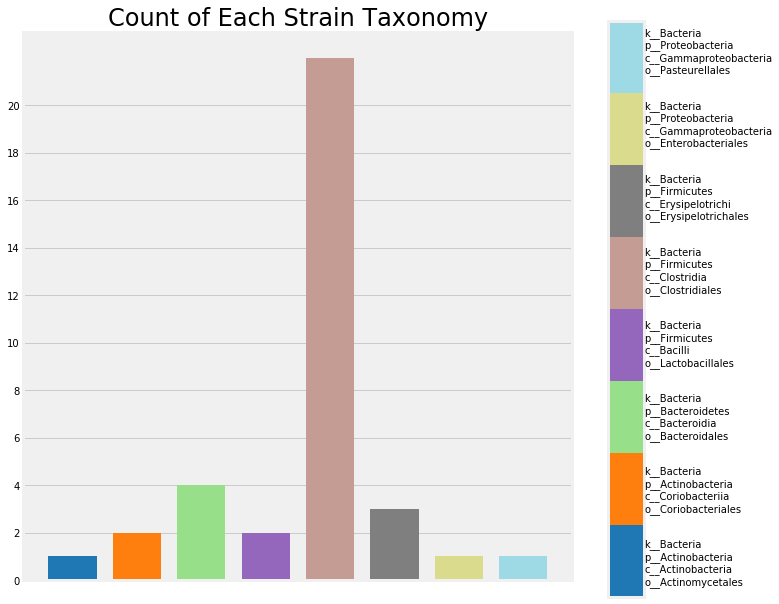

In [345]:
fig, ax = plt.subplots(figsize=(10, 8))
bar_width = 0.750
rects1 = ax.bar(np.arange(len(labels)), counts[0], bar_width, color=colors)
sm = ScalarMappable(cmap=cmap)
sm.set_array([])
ax.set_xticks([])
ax.set_yticks(list(range(22))[::2])
plt.tight_layout()
plt.title('Count of Each Strain Taxonomy', fontsize=24)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.0, 0.05, 1])
cb = plt.colorbar(sm, cax=cbar_ax)
cb.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(labels):
    cb.ax.text(1, 0.02 + (3.3 * j + 1) / 26.0, lab, ha='left', va='center', fontsize=10)

In [188]:
means_arr = np.array(means)
group_means = means_arr.mean(axis=0)
print(group_means)

[ 206.48375485   78.76322886 4771.20497868  126.28633363  891.64664509
  409.5593748  2322.59580779  499.91256716]


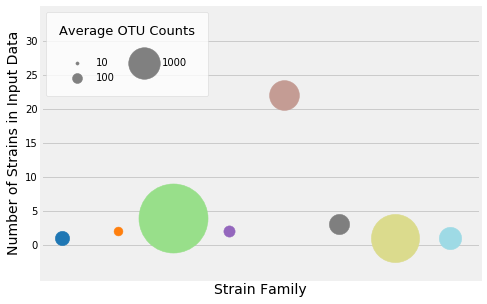

In [223]:
fig, ax = plt.subplots(figsize=(7, 5))
for i in range(len(counts[0])):
    plt.scatter(i, counts[0][i], s=group_means[i], c=colors[i])
plt.ylim(-5, 35)
plt.scatter([],[], s=10, label='10', color='gray')

plt.scatter([],[], s=100, label='100', color='gray')
plt.scatter([],[], s=1000, label='1000', color='gray')
leg_labels = ["10", "100", "1000"]
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks(list(range(0, 35))[::5])
ax.set_yticklabels(list(range(0, 35))[::5])
legend = plt.legend(frameon = 1, 
                    loc='upper left', 
                    fontsize=10, 
                    ncol=2, 
                    title='Average OTU Counts\n', 
                    borderpad = 1.3)
legend.get_title().set_fontsize('13') 
frame = legend.get_frame()
frame.set_facecolor('white')

plt.xlabel('Strain Family', fontsize=14)
plt.ylabel('Number of Strains in Input Data', fontsize=14)
# plt.title('Count of Number of Strains Per Family\nand Average OTU Count', fontsize=24, y=1.01)


plt.show()

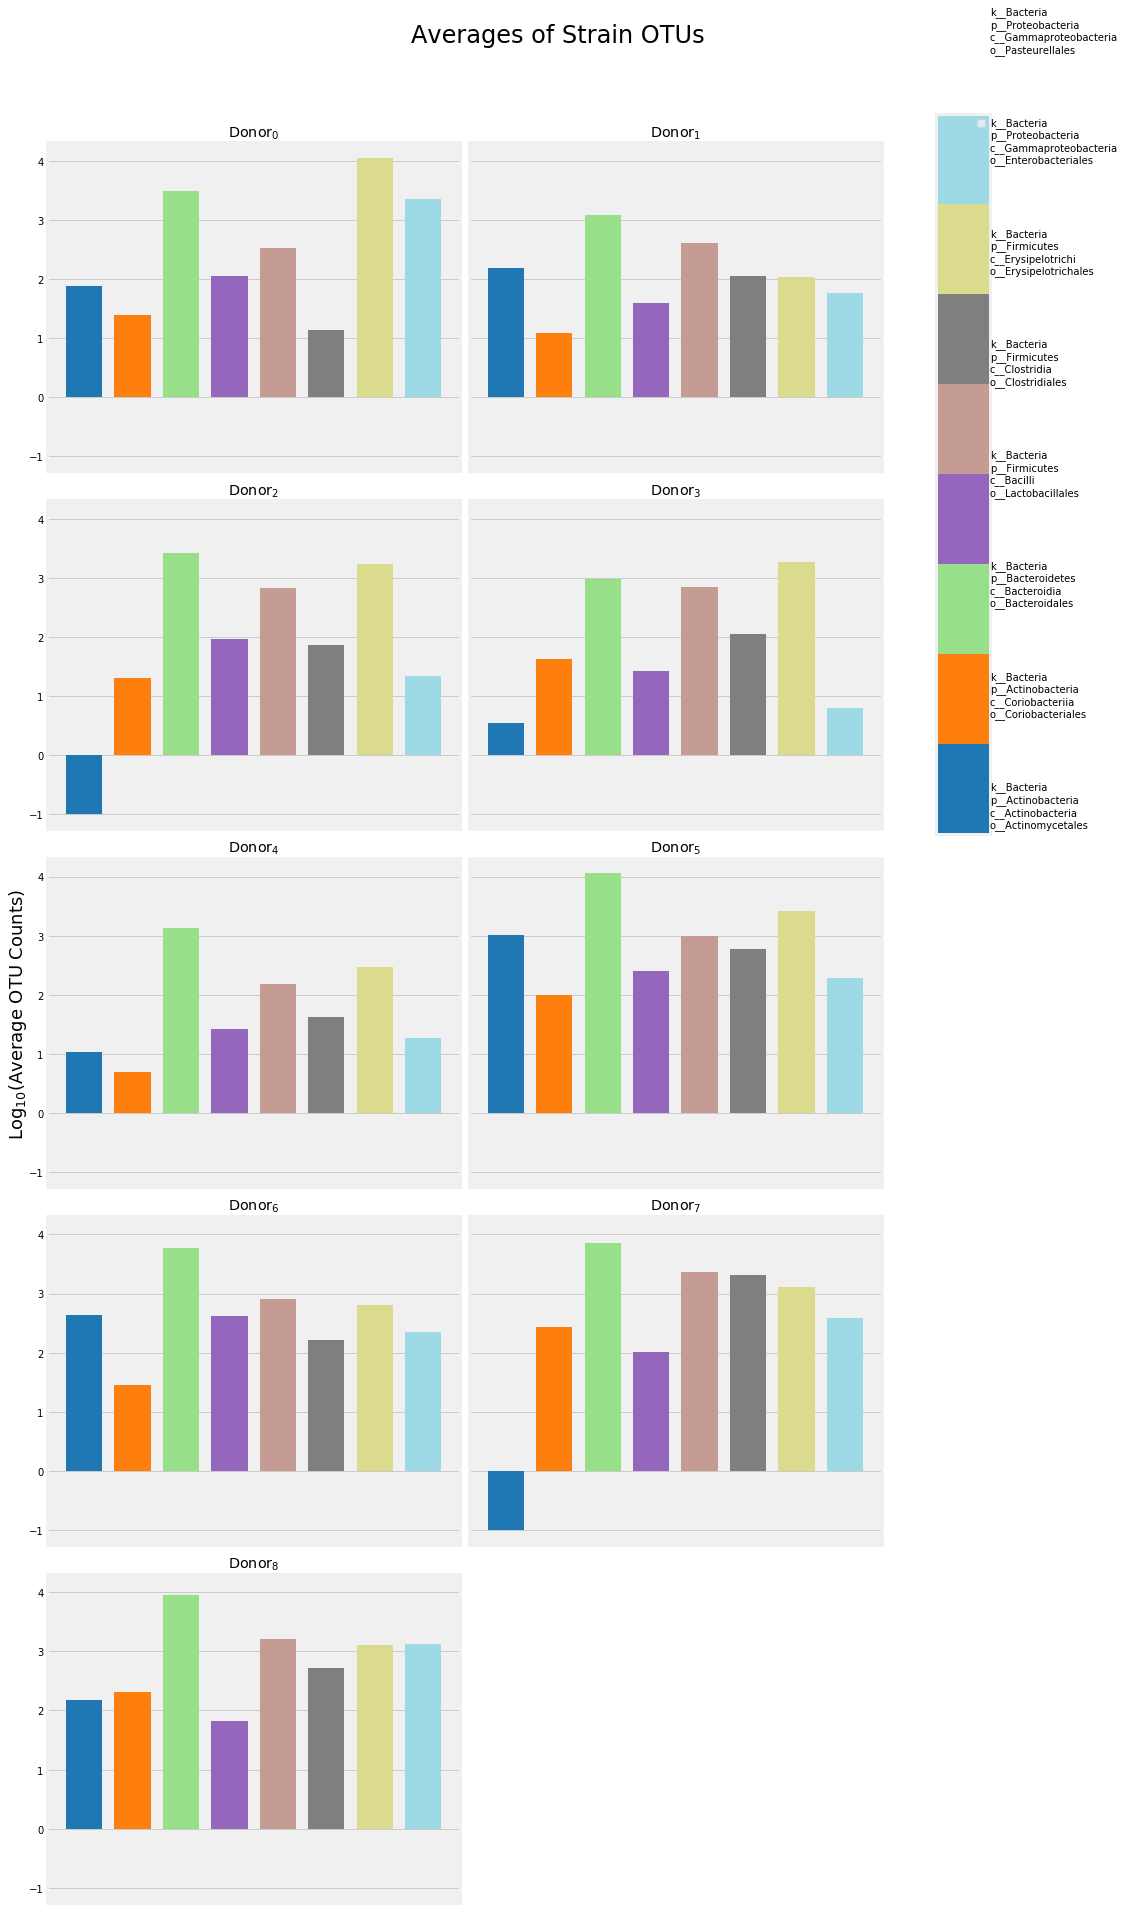

In [190]:

fig, ax = plt.subplots(num_rows, num_cols, figsize=(subplot_width, subplot_height), 
                       sharex=True, sharey=True)
axl = ax.flatten()

for i, c in enumerate(counts):
    bar_width = 0.750
    rects1 = axl[i].bar(np.arange(len(labels)), np.log10(means[i]), bar_width, color=colors)
    sm = ScalarMappable(cmap=cmap)
    sm.set_array([])
    axl[i].set_xticks([])
    axl[i].set_title(file_labs[i])
    plt.tight_layout()

# This is all to get the colorbar on the right.
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, colorbar_start, 0.05, colorbar_height])
cb = plt.colorbar(sm, cax=cbar_ax)
cb.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(labels):
    cb.ax.text(1, (4 * j + 1) / 26.0, lab, ha='left', va='center', fontsize=10)

plt.suptitle('Averages of Strain OTUs', y=1.05, fontsize=24)
plt.legend(loc='upper right')
fig.text(-0.01, 0.5, 'Log$_{10}$(Average OTU Counts)', va='center', rotation='vertical', fontsize=18)

# Cleanup
if num_rows * num_cols != len(oh.samples):
    ax[-1, -1].axis('off')
    
plt.show()

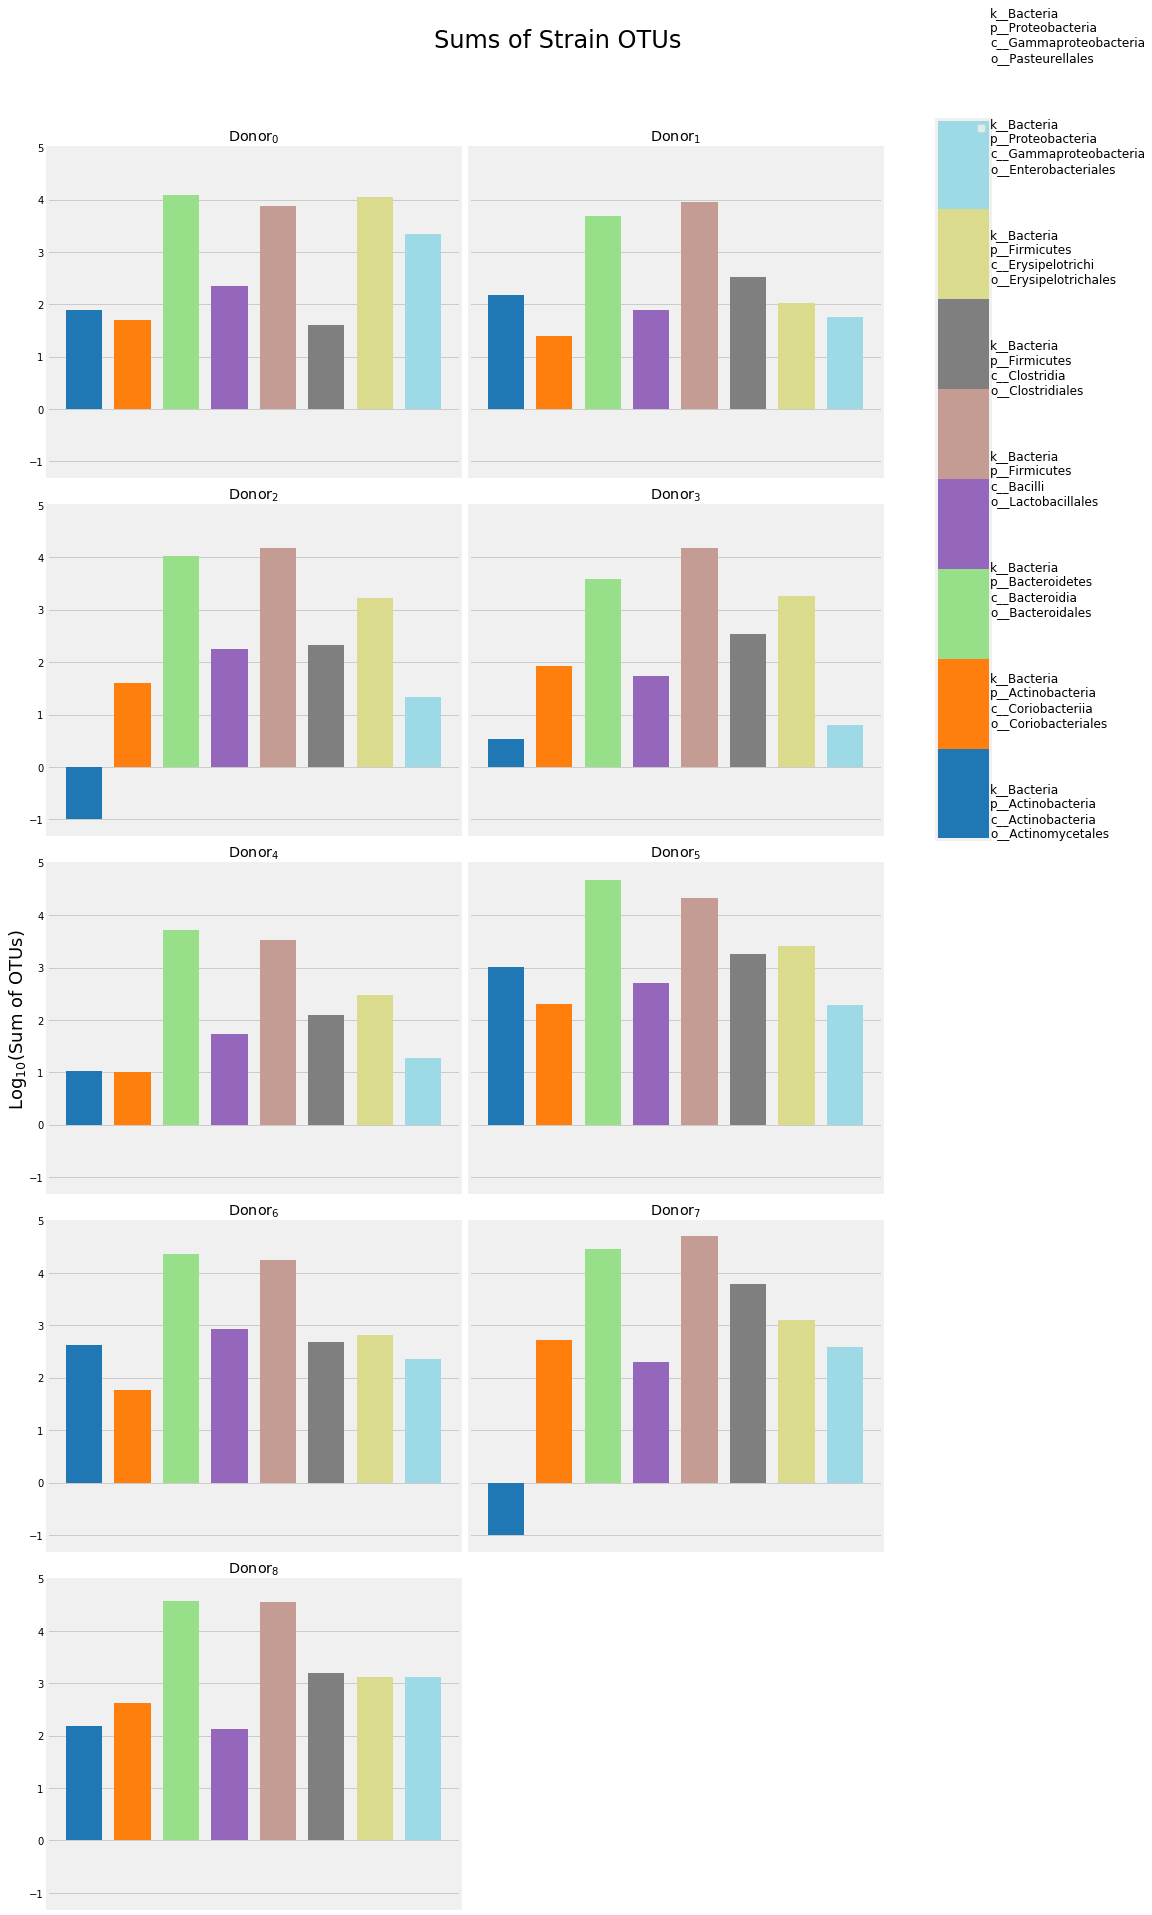

In [191]:
fig, ax = plt.subplots(num_rows, num_cols, figsize=(subplot_width, subplot_height), sharex=True, sharey=True)
axl = ax.flatten()

for i, c in enumerate(counts):
    bar_width = 0.750
    rects1 = axl[i].bar(np.arange(len(labels)), np.log10(sums[i]), bar_width, color=colors)
    sm = ScalarMappable(cmap=cmap)
    sm.set_array([])
    axl[i].set_xticks([])
    axl[i].set_title(file_labs[i])
    plt.tight_layout()

# This is all to get the colorbar on the right.
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, colorbar_start, 0.05, colorbar_height])
cb = plt.colorbar(sm, cax=cbar_ax)
cb.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(labels):
    cb.ax.text(1, (4 * j + 1) / 26.0, lab, ha='left', va='center', fontsize=12)

plt.suptitle('Sums of Strain OTUs', y=1.05, fontsize=24)
plt.legend(loc='upper right')
fig.text(-0.01, 0.5, 'Log$_{10}$(Sum of OTUs)', va='center', rotation='vertical', fontsize=18)

# Cleanup
if num_rows * num_cols != len(oh.samples):
    ax[-1, -1].axis('off')
plt.show()

# Cosine distance between samples
Given the discrepancies between the samples as seen above, let's get a more concrete measure of their difference.

In [224]:
# Take the mean over time of each sample

donor_means = [s.values.mean(axis=1) for s in oh.samples]
donor_means = [m / (1.0 * m.sum()) for m in donor_means]

donor_stds = [s.values.std(axis=1) for s in oh.samples]


In [225]:
# Empty array for our distances
outputs = []
for data in [donor_means, donor_stds]:
    dists = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        for j in range(len(data)):
            if i < j:
                dists[i, j] = None
            else:
                dists[i, j] = cosine(data[i], data[j])
    outputs.append(dists)

[Text(0.5,0,'Donor$_0$'),
 Text(1.5,0,'Donor$_1$'),
 Text(2.5,0,'Donor$_2$'),
 Text(3.5,0,'Donor$_3$'),
 Text(4.5,0,'Donor$_4$'),
 Text(5.5,0,'Donor$_5$'),
 Text(6.5,0,'Donor$_6$'),
 Text(7.5,0,'Donor$_7$'),
 Text(8.5,0,'Donor$_8$')]

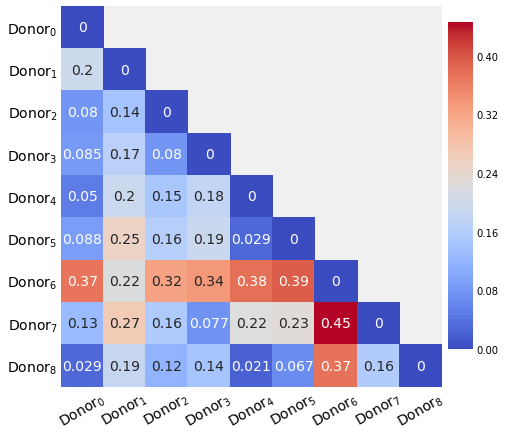

In [236]:
fig, ax = plt.subplots(figsize=(7, 7))
cbar_ax = fig.add_axes([.905, 0.2, .05, .65])

ax = sns.heatmap(outputs[0], 
                cmap='coolwarm', 
                vmax=np.nanmax(outputs[0]), 
                vmin=0,
                square=True,
                annot=outputs[0],
                yticklabels=file_labs,
                xticklabels=file_labs,
                annot_kws={'fontsize': 14},
                cbar_ax=cbar_ax,
                cbar=True,
                ax=ax)
ax.set_yticklabels(file_labs, rotation=0, fontsize=14)
ax.set_xticklabels(file_labs, rotation=30, fontsize=14)
# ax.set_title('Cosine Distances Between the\nNormalized Means of OTU Counts',
#           y=1.01, fontsize=24)

# Perform PCA on Input

/opt/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


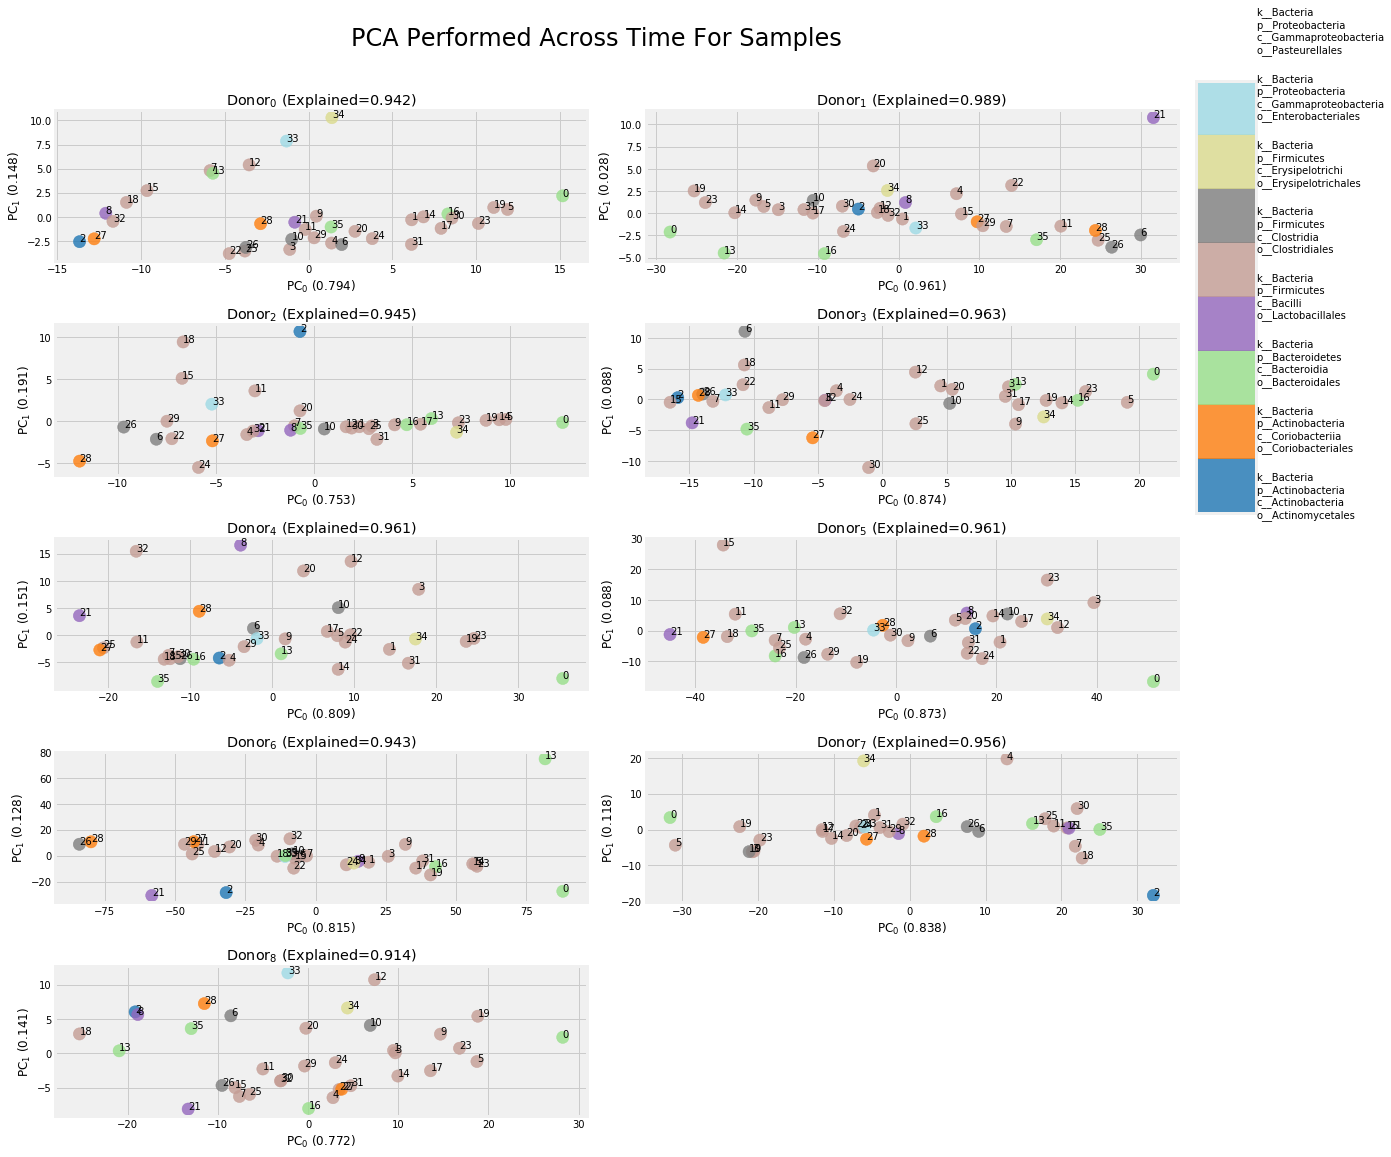

In [195]:
%matplotlib inline
num_samples = len(oh.samples)
fig, ax = plt.subplots(num_rows, num_cols, figsize=(subplot_height / 1.5, subplot_width), sharex=False, sharey=False)
axl = ax.flatten()
ts = []
exp_x = []
exp_y = []
# to_annotate = [19, 53, 46, 41, 21, 26]

for i, s in enumerate(oh.samples):
    zs = zscore(clr(s.values, axis=0), axis=0)
    pca = PCA(n_components=2)
    pca.fit(zs)
    t = pca.transform(zs)
    ts.append(t)
    exp_x.append(pca.explained_variance_ratio_[0])
    exp_y.append(pca.explained_variance_ratio_[1])
    x_vals = t[:, 0]
    y_vals = t[:, 1]
    sc = axl[i].scatter(x_vals, y_vals, c=labs_to_ints, cmap=cmap, s=150, alpha=0.8)
    axl[i].set_title('{} (Explained={})'.format(file_labs[i], 
                                               str(sum(pca.explained_variance_ratio_[:2]))[:5]
                                              ))
    axl[i].set_xlabel('PC$_0$ ({})'.format(str(pca.explained_variance_ratio_[0])[:5]))
    axl[i].set_ylabel('PC$_1$ ({})'.format(str(pca.explained_variance_ratio_[1])[:5]))
    
    # Uncommenting this will annotate each point so that you can see which it is to remove it later potentially.
    for j, txt in enumerate(full_labs):
# #         if j in to_annotate:
        axl[i].annotate(j, (x_vals[j], y_vals[j]), fontsize=10)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.0, colorbar_start, 0.05, colorbar_height])
# fig.colorbar(im, cax=cbar_ax)
cb = plt.colorbar(sc, cax=cbar_ax)
cb.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(labels):
    cb.ax.text(1, (4 * j + 1) / 26.0, lab, ha='left', va='center', fontsize=10)
plt.suptitle('PCA Performed Across Time For Samples', fontsize=24, y=1.05)
fig.tight_layout()
# Cleanup
if num_rows * num_cols != len(oh.samples):
    ax[-1, -1].axis('off')

Text(0,0.5,'PC$_1$ Explained Variance: 0.120')

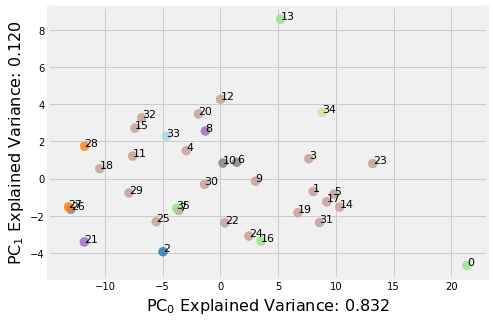

In [231]:
ts = np.array(ts)
tsm = np.mean(ts, axis=0)
plt.figure(figsize=(7,5))
expxm = np.mean(exp_x)
expym = np.mean(exp_y)
plt.scatter(tsm[:, 0], tsm[:, 1], cmap=cmap, c=labs_to_ints, alpha=0.8, s=80)
for j, txt in enumerate(full_labs):
    plt.annotate(j, (tsm[j, 0], tsm[j, 1]), fontsize=11)
plt.xlabel('PC$_0$ Explained Variance: {}'.format(str(expxm)[:5]), fontsize=16)
plt.ylabel('PC$_1$ Explained Variance: {}'.format(str(expym)[:5]), fontsize=16)

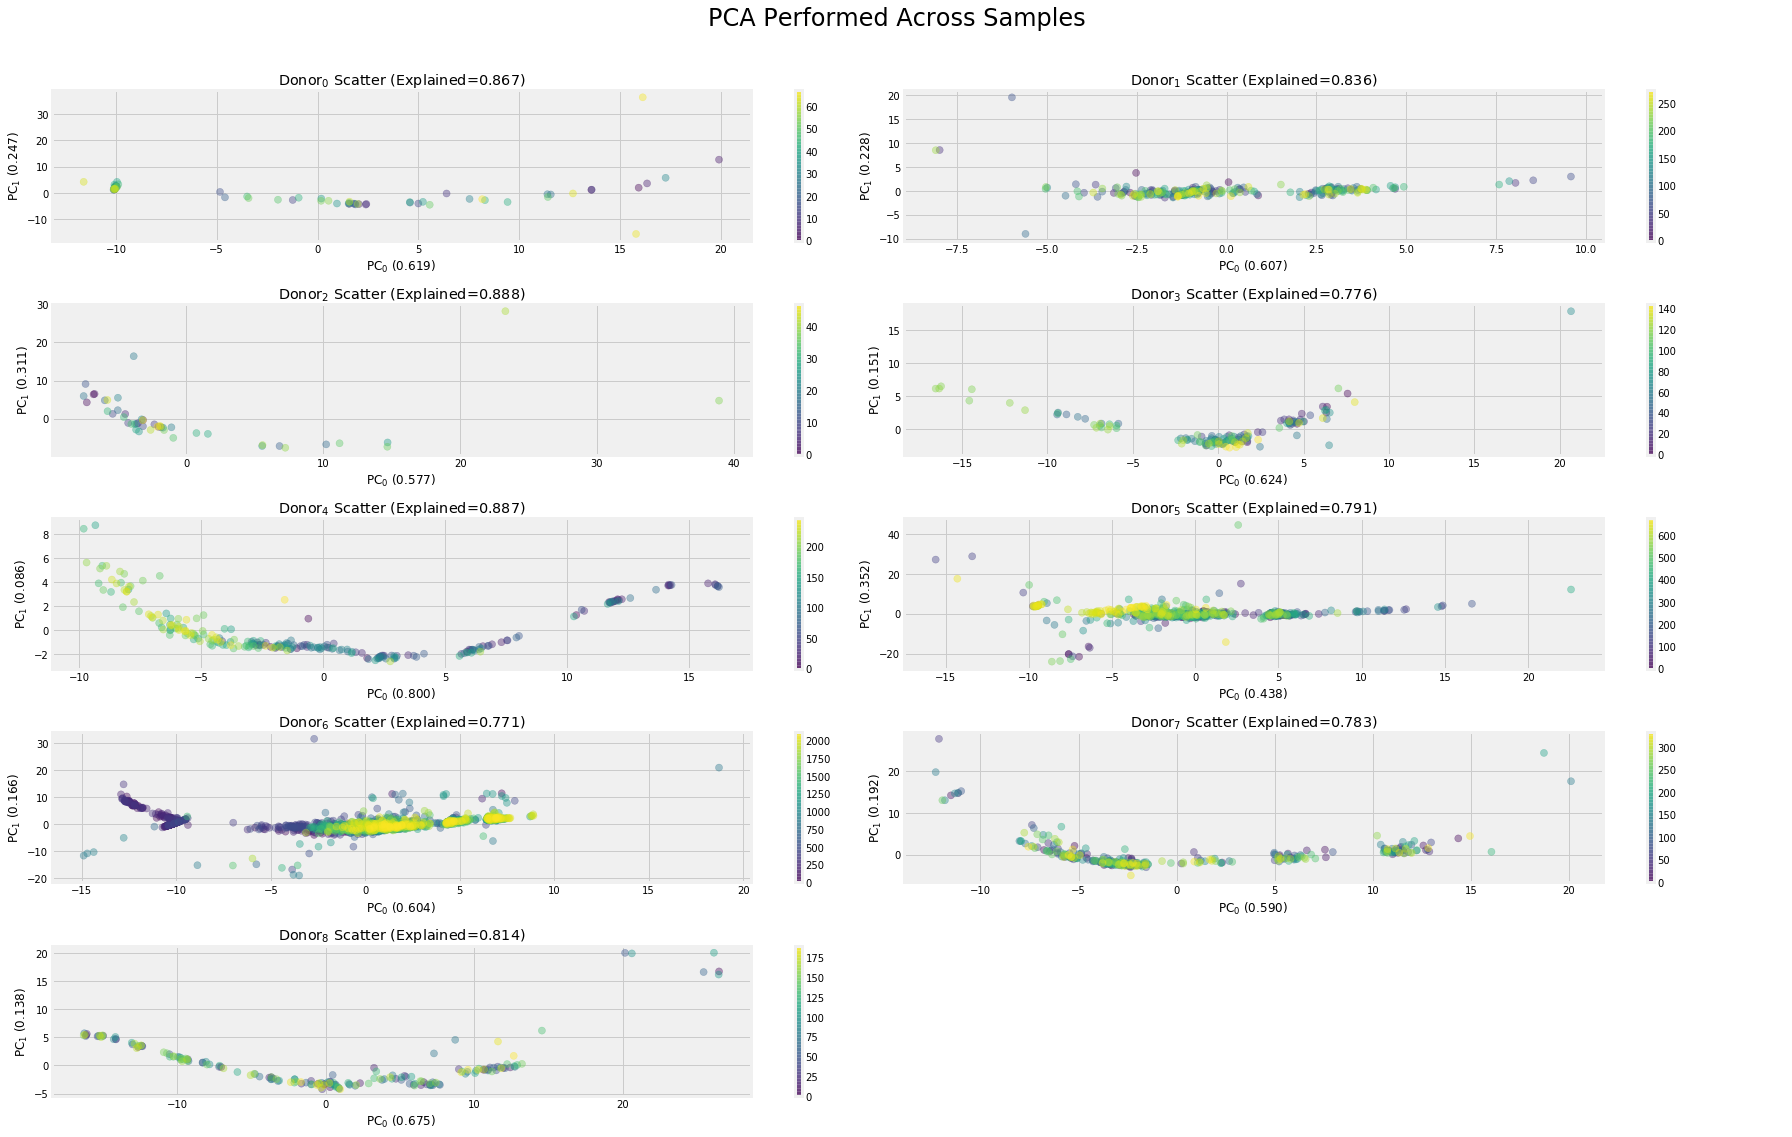

In [197]:

fig, ax = plt.subplots(num_rows, num_cols, figsize=(subplot_height, subplot_width), sharex=False, sharey=False)
axl = ax.flatten()
for i, s in enumerate(oh.samples):
    zs = clr(s.values, axis=1).T
    pca = PCA(n_components=2)
    pca.fit(zs)
    t = pca.transform(zs)
    sc = axl[i].scatter(t[:, 0], t[:, 1], c=range(t.shape[0]), cmap='viridis', s=50, alpha=0.4)
    axl[i].set_title('{} Scatter (Explained={})'.format(file_labs[i], 
                                                       str(sum(pca.explained_variance_ratio_[:2]))[:5]
                                                      ))
    axl[i].set_xlabel('PC$_0$ ({})'.format(str(pca.explained_variance_ratio_[0])[:5]))
    axl[i].set_ylabel('PC$_1$ ({})'.format(str(pca.explained_variance_ratio_[1])[:5]))
    cb = plt.colorbar(sc, ax=axl[i])
plt.suptitle('PCA Performed Across Samples', fontsize=24, y=1.05)
fig.tight_layout()
# Cleanup
if num_rows * num_cols != len(oh.samples):
    ax[-1, -1].axis('off')
plt.show()

In [199]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
cmap1 = get_cmap(len(oh.samples) + 1)
colors2 = [cmap1(i) for i in range(len(file_labs))]
random.shuffle(colors2)


In [350]:

cmap = matplotlib.cm.get_cmap('Set1')

In [352]:
cmap(0)

(0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)

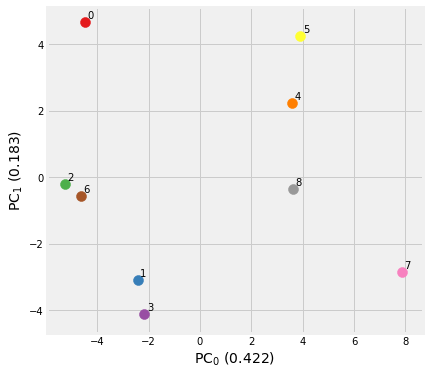

In [361]:


fig, ax = plt.subplots(figsize=(6, 6))

means = [np.mean(s, axis=1) for s in oh.samples]
s = np.array(means)

zs = clr(s, axis=1)
pca = PCA(n_components=2)
pca.fit(zs)
t = pca.transform(zs)

for i in range(t.shape[0]):
    plt.scatter(t[i, 0], t[i, 1], label=file_labs[i], s=100, c=cmap(i))
    plt.annotate(i, (t[i, 0] + 0.1, t[i, 1] + 0.1))
# legend = plt.legend(frameon = 1, loc='upper right', ncol=1, fontsize=12, bbox_to_anchor=(1.2, 1))
frame = legend.get_frame()
frame.set_facecolor('white')
ax.set_xlabel('PC$_0$ ({})'.format(str(pca.explained_variance_ratio_[0])[:5]), fontsize=14)
ax.set_ylabel('PC$_1$ ({})'.format(str(pca.explained_variance_ratio_[1])[:5]), fontsize=14)
# plt.title('PCA Performed Across Donors\n(Explained={})'.format(str(sum(pca.explained_variance_ratio_[:2]))[:5]), 
#           fontsize=24, y=1)
plt.show()

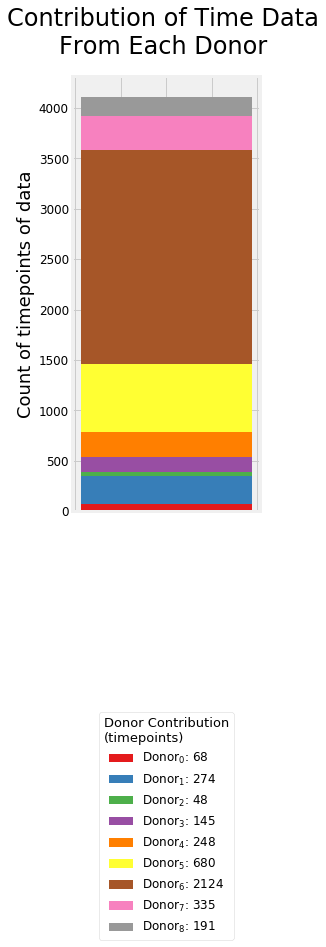

In [354]:
su = sum([s.shape[1] for s in oh.samples])
fracs = [s.shape[1] * 1.0 / su for s in oh.samples]
sizes = [s.shape[1] for s in oh.samples]


fig, ax = plt.subplots(figsize=(3, 8))
bar_width = 0.750
for i in range(len(fracs)):
    if i == 0:
        ax.bar(1, sizes[i], bar_width, color=cmap(i), label=file_labs[i] + ': {}'.format(sizes[i]))
    else:
        ax.bar(1, sizes[i], bar_width, color=cmap(i), bottom=sum(sizes[:i]), label=file_labs[i] + ': {}'.format(sizes[i]))

ax.set_xticklabels([])
plt.ylabel('Count of timepoints of data', fontsize=18)
ax.tick_params(axis='y', which='major', labelsize=12)
plt.suptitle('Contribution of Time Data\nFrom Each Donor', fontsize=24, y=1)
legend = plt.legend(frameon = 1, 
                    loc='lower center', 
                    fontsize=12, 
                    ncol=1,
                    bbox_to_anchor=(0.5, -1),
                    title='Donor Contribution\n(timepoints)'
                    )
legend.get_title().set_fontsize('13') 
frame = legend.get_frame()
frame.set_facecolor('white')

# ax.set_ylim(0, 1)
plt.show()

In [337]:
train_hardest = [2, 18, 13, 34, 15, 0, 12, 6, 8, 30, 33, 21, 4, 3, 32]
val_hardest = [0, 2, 21, 34, 4, 35, 15, 32, 8, 18, 14, 19, 28, 26, 7]
test_hardest = [25, 21, 6, 24, 34, 18, 11, 13, 32, 35, 9, 30, 10, 33, 2]

train_labs = [full_labs[i] for i in train_hardest]
val_labs = [full_labs[i] for i in val_hardest]
test_labs = [full_labs[i] for i in test_hardest]
# print([set(train_labs), set(val_labs), set(test_labs)])

# print('\n\n'.join(train_labs))
len(set(train_labs).intersection(set(test_labs)))

9